# <font color=blue> *Text Data Analysis Notebook* </font>
Book Recommender System<br>
Sabrina Ruiz

# Introduction
In this notebook, I will optimize the text vectorization and processing for the `review` column of my cleaned data. I will create a custom tokenizer to best fit my data set. Lastly, I will test the text processing through a basic model.  

# Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from imblearn.under_sampling import RandomUnderSampler


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
stemmer = nltk.stem.PorterStemmer()
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.compose import ColumnTransformer

from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# setting a color palette for Seaborn visualizations
bright_palette = sns.set_palette(palette = "bright")

#other visual standards
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/My Drive/combined_book_data_cut.csv', index_col=0)
data.head() # takes about 60 secs

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography


In [6]:
data.shape

(2616533, 10)

# Exploring Sentiment
for the purposes of exploring general sentiment, I will convert the `review_score` to a binary representing *positive* and *negative* sentiment. Next, I will explore the possibility of a multiclass classifier. A multiclass system would perhaps addresess any issues brought about with a simple binary.

For the purpose of this project, I will set ***negative*** sentiment to be scores of 3 and below, and ***positive*** sentiment to be scores 4 & 5. Ultimately, I wish to train my final book recommender model on elementary school book data for children to use. In my experience, children tend to be more polar in the likes and dislikes.

#### "Positive" & "Negative" Sentiment

In [7]:
#creating a new df, binary sentiment
pos_neg_df = data.copy()
pos_neg_df.head(2)

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography


In [8]:

pos_neg_df['review_score'] = np.where(pos_neg_df['review_score'] > 3, 1, 0)
# change column name to reflect changes
pos_neg_df.rename(columns={"review_score": "sentiment"}, inplace=True)
pos_neg_df.head()

,Id,Title,User_id,profileName,sentiment,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",1,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,1,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",1,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",1,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography


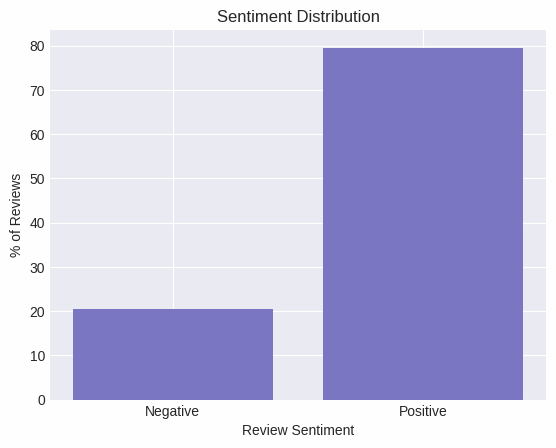

Class imbalance: [0.2 0.8]


In [11]:
values, counts = np.unique(pos_neg_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.title("Sentiment Distribution")
plt.bar(["Negative", "Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is quite inbalanced! To be more precise, [Google](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) would classify this as a "moderate" degree of imbalance.
#### MultiClass Sentiment
Let's explore having a three-class division of sentiment, with a score of 3 being "neutral."

In [ ]:
#create new df for 3 classes
three_class_df = data.copy()
#divide rating to 3
three_class_df['sentiment'] = np.select([three_class_df['review_score'] == 1,
                                         three_class_df['review_score'] == 2,
                                         three_class_df['review_score'] == 3,
                                         three_class_df['review_score'] == 4,
                                         three_class_df['review_score'] == 5],
                                          [0,0,1,1,2], default=np.nan)
three_class_df

,Unnamed: 0,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories,sentiment
0,0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels,1.0
1,1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography,2.0
2,2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography,2.0
3,3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography,1.0
4,4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2974297,2999787,B000NSLVCU,The Idea of History,unknown,unknown,4,Difficult,"This is an extremely difficult book to digest,...",R. G. Collingwood,2018.0,History,1.0
2974298,2999788,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...,R. G. Collingwood,2018.0,History,1.0
2974299,2999789,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i...",R. G. Collingwood,2018.0,History,1.0
2974300,2999790,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,...",R. G. Collingwood,2018.0,History,2.0


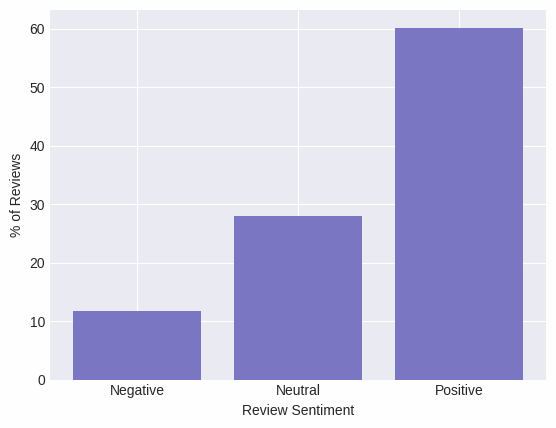

Class imbalance: [0.12 0.28 0.6 ]


In [ ]:
values, counts = np.unique(three_class_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["Negative", "Neutral","Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is still pretty biased, and not an accurate division between the three classifications.

#### Addressing Data Inbalance

I will take the following steps to address the data inbalance:


1.   **Do nothing:** I will see if the imbalance affects results. If issues arise, I will move on to step 2.
2.   **Undersampling** I will attempt removing reviews of the majority class, "positive sentiment." Seeing as this is a large dataset, for the sake of computing power and efficiency, I decided "oversampling" would be less ideal.

Any steps taken will be during or after the train-test split so as to have the test data remain as real as possible.



# Preprocessing

For the sake of processing power, only a sample of the data as shown in the code below, will be selected. This number was increased as much as possible using Google Colab's CPU.

In [67]:
#Which is my final working dataframe?
modeling_df = data.sample(n=10000, random_state=18)
modeling_df

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
2476676,096406054X,Mouse Tales: A Behind-the-Ears Look at Disneyl...,A89Y6WZKEP069,Jewelz- Theo's Mom,2,Caution: You may lose a bit of the magic....,This is a very well written book about the inn...,David Koenig,2005.0,Biography & Autobiography
2941482,B000MC7FBS,WAR AS I KNEW IT.,A3KFFGZCE3R836,Steven Patton,5,War as I knew it.,Fantastic! Wish we had a leader such as him to...,George Smith Patton,1980.0,Generals
141151,B000KIT9U4,The Shelters Of Stone - The Earth's Children S...,A5XSPTAK24CDZ,HannahR,1,Puh-leese...,"...hindsight being 20/20, I would have wished ...",Jean M. Auel,2002.0,Fiction
2153415,B000KAFUP0,The Clear and Simple Thesaurus Dictionary,AFHYEO3Y1IIDD,maximum verbosity,5,"Different than expected, but still happy",I thought this book was for a little bit young...,"Harriet Wittels', 'Joan Greisman",2006.0,Juvenile Nonfiction
2853977,1590591518,Learn to Program with Visual Basic 6,A12KQ3ZZO00ZBX,K. Schaller,4,Effective teaching technique,Mr. Smiley uses the approach of solving real-w...,John Smiley,2003.0,uncategorized
...,...,...,...,...,...,...,...,...,...,...
2757240,B000GXF3QC,Angel Letters,unknown,unknown,5,Ordinary people who've had extraordinary exper...,I read the hardcover edition of this book a co...,NaN,NaN,uncategorized
645951,B000OVOI1W,Star Wars Agents Of Chaos 1 Hero's Trial,unknown,unknown,5,Very Good,Luceno did a great job capturing Han Solo's pe...,James Luceno,2000.0,Fiction
2065302,0793169445,Passtrak Series 7: General Securities Represen...,unknown,unknown,3,If you can get through the book it is ok,"As one other reader mentioned, there are some ...",Dearborn,2004.0,Business & Economics
894550,B00085BGPA,Grace abounding to the chief of sinners & The ...,A1XW7S2LTIW3FW,Ian H. Clary,5,A great theologian,"I can't say that I have read this book...yet, ...",John Bunyan,1863.0,uncategorized


In [64]:
X = modeling_df[['Title','User_id', 'review']]
y = modeling_df['review_score']

In [65]:
# splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18, stratify=y)
# 10 secs

In [66]:
X_train

,Title,User_id,review
1603067,Northanger abbey (The World's classics),unknown,it was a good book but very hard to get into. ...
1127803,Ariel,A24N89UJ3OLEC3,It seems every morbid well read teenage girl w...
2960473,The Complete Encyclopedia of Pistols and Revol...,A3GEBPIJQNUYZF,... but watch it on the details. Not all &#34;...
2628839,Middlesex [Unabridged Audiobook],A2MQQI4UYT9C11,The best book I read in June 2007 (and probabl...
313234,Above the Law: A Novel,A1TEXM8QUJ08DK,I have read both &quot;Above the Law&quot; and...
...,...,...,...
104799,The Stranger,unknown,It's really good because one of the main chara...
1891931,The Right Nation: Conservative Power in America,A2DMX9ASE4KH40,An avid reader and student of American politic...
2117361,Cinderella,A6DYVD7HJTP5A,This book is indeed ready for the Ball. It is ...
1041492,Singular Intimacies: Becoming a Doctor at Bell...,unknown,"With wry humor, grace, honesty, and intelligen..."


In [61]:
print("The train-test variable shapes:")
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

The train-test variable shapes:
X_train: (750000, 9)
X_test: (250000, 9)


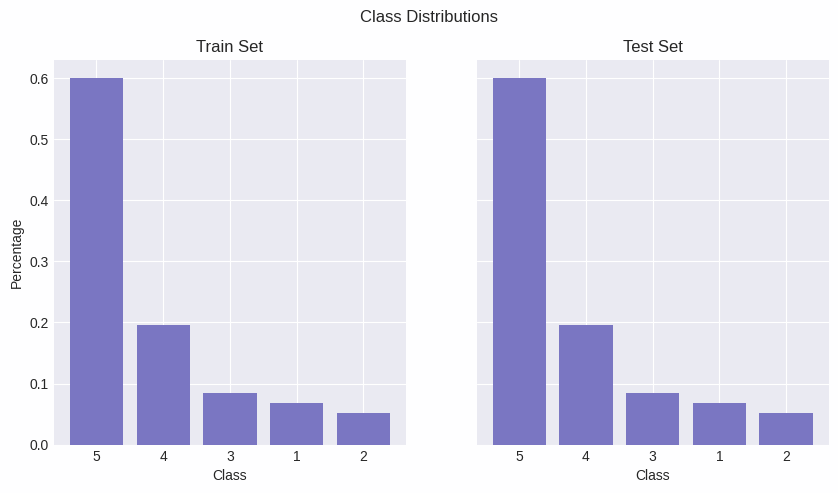

In [52]:
# Get the value counts of our train and test sets
y_train_vals = y_train.value_counts()
y_test_vals = y_test.value_counts()

# Plot the distributions to check if they match the original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.bar(y_train_vals.index.astype(str), y_train_vals.values/sum(y_train_vals.values))
ax2.bar(y_test_vals.index.astype(str), y_test_vals.values/sum(y_test_vals.values))
plt.suptitle("Class Distributions")
ax1.set_title("Train Set")
ax1.set_xlabel("Class")
ax1.set_ylabel("Percentage")
ax2.set_title("Test Set")
ax2.set_xlabel("Class")
plt.show()

This ensured that the train-test split maintained the same distribution as the original dataset.

##### Undersampling test data

#### Bag of Words Vectorizer
I will put my dataset through various versions of a CountVectorizer to see which yields the best results. First, I will start off with a standard one of simple English stop words and max the features at 500.

In [26]:
#words aside from stop words to ignore
MY_STOP_WORDS = stopwords.words('english')
GENERIC_WORDS = ["book" , "author" , "read" , "character" , "story" , "page" , "write" , "series" , "review"]
MY_STOP_WORDS.extend(GENERIC_WORDS)

In [ ]:
working_cv = CountVectorizer(stop_words=MY_STOP_WORDS, min_df=10, max_features=1000)
working_cv.fit(X_train['review'])
X_train_transformed = working_cv.transform(X_train['review'])
X_test_transformed = working_cv.transform(X_test['review'])
X_test_transformed.shape
#cell takes 12 mins

(594861, 1000)

In [ ]:
#visualizing most common  wds

word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=working_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.6020859281145655
Test score: 0.6026428396772353


Although 65% may seem low, this is simply a baseline score. There was no hyperoptimization or customization done. From the simple logistic regression, here is a viualization of the top words with positive sentiment:

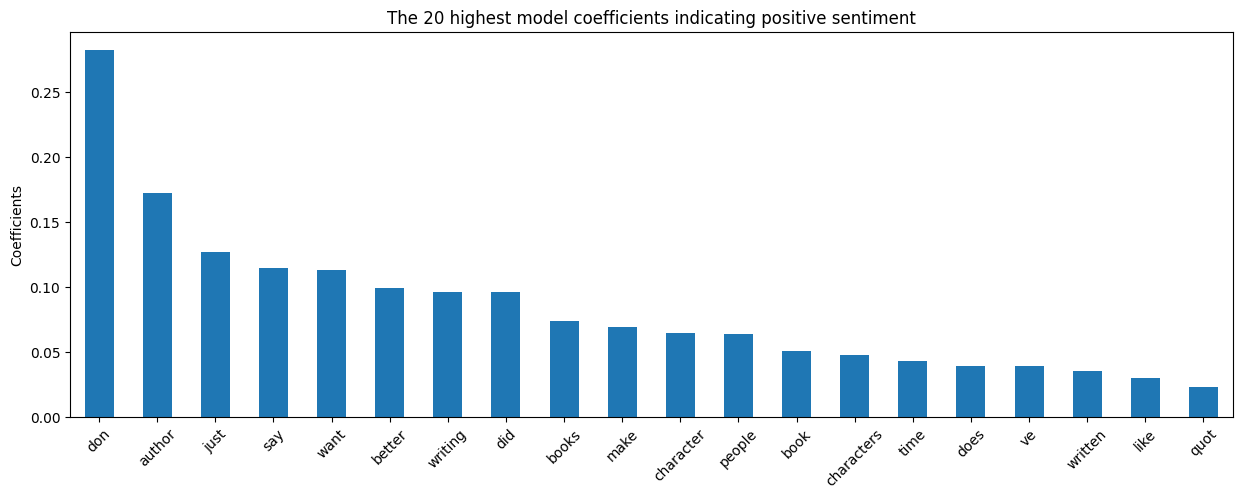

In [ ]:
#visualizing positive sentiment
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=working_cv.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()


The words do not seem to have positive sentiment, but rather the opposite. It seems I have misinterpreted my input.

#### Building a Custom Tokenizer

Next, I will attempt to create a custom tokenizer to best fit and optimize the model.

In [ ]:
#words aside from stop words to ignore
MY_STOP_WORDS = stopwords.words('english')
GENERIC_WORDS = ["book" , "author" , "read" , "character" , "story" , "page" , "write" , "series" , "review"]
MY_STOP_WORDS.extend(GENERIC_WORDS)

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []

    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in MY_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [ ]:
# MY_STOP_WORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# sanity check
sentence = "Can you believe that: his (dog) like, read my book!"
my_tokenizer(sentence)

['believ', 'dog', 'like']

The words on my added stop list seem to be removed as well! This seems like a good start. I will put this tokenizer to the test.

In [ ]:
custom_cv = CountVectorizer(min_df =5,
                            max_features= 1000,
                            tokenizer=my_tokenizer)
custom_cv.fit(X_train['review'])

X_train_custom_transformed = custom_cv.transform(X_train['review'])
X_test_custom_transformed = custom_cv.transform(X_test['review'])

X_train_custom_transformed.shape

(1992782, 1000)

In [ ]:
X_train_custom_transformed

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

Upon reruning the cell for final submission, this error message appeared. It seems something changed since the last run, so I will address this  at a later date.

In [ ]:
word_counts = pd.DataFrame(
    {"counts": X_train_custom_transformed.toarray().sum(axis=0)},
    index=custom_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Fitting a model
logreg_for_custom_cv = LogisticRegression(C = 0.1)
logreg_for_custom_cv.fit(X_train_custom_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_custom_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_custom_transformed, y_test)}")

#### TF-IDF Version

In [73]:
tfidf = TfidfVectorizer(stop_words=MY_STOP_WORDS,
                        min_df=5, #min_df=5,
                        max_features=1000
                        )
tfidf.fit(X_train.review)

X_train_transformed_tfidf = tfidf.transform(X_train.review)
X_test_transformed_tfidf = tfidf.transform(X_test.review)

X_train_transformed_tfidf.shape
#cell takes 10 mins

(750000, 1000)

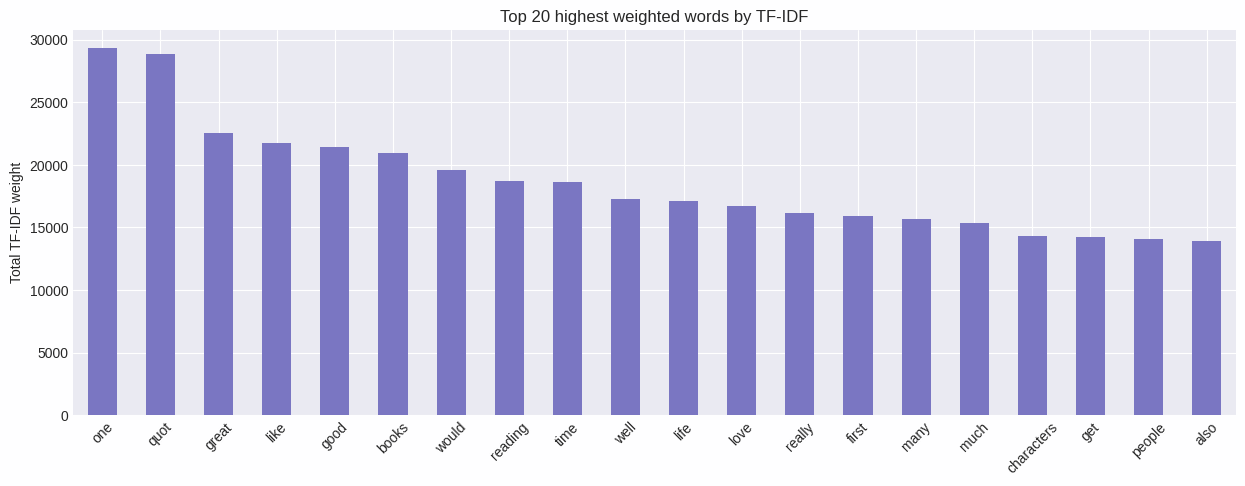

In [74]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed_tfidf.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [15]:
#Save vectorizer.vocabulary_
pickle.dump(tfidf.vocabulary_,open("/content/drive/My Drive/feature.pkl","wb"))

In [11]:
import pickle

# Pickle the tfidf object
with open('/content/drive/My Drive/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [14]:
# Pickle the tfidf fitted
with open('/content/drive/My Drive/tfidf_fit.pkl', 'wb') as file:
    pickle.dump(testing_pickle, file)

In [29]:
# Fitting a model
logreg_tfidf = LogisticRegression(C = 0.1)
logreg_tfidf.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_tfidf.score(X_train_transformed_tfidf, y_train)}")
print(f"Test score: {logreg_tfidf.score(X_test_transformed_tfidf, y_test)}")

Train score: 0.6482744340379801
Test score: 0.6472813901345291


# BERT
This [link](https://medium.com/@manindersingh120996/accelerate-your-text-data-analysis-with-custom-bert-word-embeddings-and-tensorflow-45590cf9c54)

In [75]:
#importing libraries for BERT text embedding
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#load data, and encode with tensor tokenizer
text_data = X_train.review

encoded_data = tokenizer.batch_encode_plus(text_data,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           return_token_type_ids=False,
                                           pad_to_max_length=True
                                           )

In [ ]:
convert to tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': encoded_data['input_ids'], 'attention_mask': encoded_data['attention_mask']}, np.zeros(len(encoded_data['input_ids']))))

In [ ]:
type(dataset)

In [ ]:
convert to tensorflow df
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': encoded_data['input_ids'],
                                               'attention_mask': encoded_data['attention_mask']},
                                              np.zeros(len(encoded_data['input_ids']))))

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
embedding_layer = GlobalAveragePooling1D()(bert_output)
embedding_model = Model(inputs=[input_ids, attention_mask], outputs=embedding_layer)

# Tensor Flow V2

# Word2Vec Method
[link](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673)

# Building a Recommender System

In [ ]:
# Cosine Similarity
similarities = cosine_similarity(TF_IDF_matrix, dense_output=False)

# Notes for Next Steps

Moving forward, I will work on the following steps:
1. address data inbalance
    - perhaps downsize positive sentiment data, or change the positive sentiment cutoff point
2. get TO Modeling
    - I will decide between a “recommendation” system or with a simple rating predictor as before. At the moment, I am leaning toward a real recommendation system as opposed to a simple output list based off top predicted ratings.
    - Perhaps I wil do unsupervised -cluster --> recommender
3. sentiment classifying Tweaks
    - It seems I must fix my custom tokenizer - fix stemming, common words, add web embedding upon recommendation of instructor following today's presentation

### multiclass classification
One thing I can look into is perhaps testing a multiclass classifier as a way to address the data inbalance.
    

### Some personal notes to be deleted
    - Multiclassifier: wont inherinly understand 5 is good, 0 bad, but all the ratings will be categorized as such.
    - ordinal regression model
    - ordinal encoding
    - see if the model does better this way?
    -would be a way to address the data imbalance
    
    -neaural net
    decision tree
    svms
    knn